In [1]:
# import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import r2_score, accuracy_score, classification_report, mean_squared_error
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

# import models
from xgboost import XGBRegressor, XGBClassifier, plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# set plot style
sns.set(style="whitegrid")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset

In [2]:
# load the training set and test set
train_data = pd.read_csv('option_train.csv')
test_data = pd.read_csv('option_test_wolabel.csv')

In [3]:
# check missing value
print("Training Data Missing Values Statistics:")
print(train_data.isnull().sum())

# use median imputation for numerical variables
numeric_features = ['Value', 'S', 'K', 'tau', 'r']
for feature in numeric_features:
    median_value = train_data[feature].median()
    train_data[feature].fillna(median_value, inplace=True)

# use mode imputation for categorical variables
categorical_features = ['BS']
for feature in categorical_features:
    mode_value = train_data[feature].mode()[0]
    train_data[feature].fillna(mode_value, inplace=True)

# confirm that missing values have been handled
print("\nAfter handling missing values, training data missing values statistics:")
print(train_data.isnull().sum())

# apply the same processing to the test set
print("\nTest Data Missing Values Statistics:")
print(test_data.isnull().sum())

for feature in ['S', 'K', 'tau', 'r']:
    median_value = train_data[feature].median()
    test_data[feature].fillna(median_value, inplace=True)

print("\nAfter handling missing values, test data missing values statistics:")
print(test_data.isnull().sum())

Training Data Missing Values Statistics:
Value    1
S        1
K        2
tau      1
r        0
BS       0
dtype: int64

After handling missing values, training data missing values statistics:
Value    0
S        0
K        0
tau      0
r        0
BS       0
dtype: int64

Test Data Missing Values Statistics:
S      0
K      0
tau    0
r      0
dtype: int64

After handling missing values, test data missing values statistics:
S      0
K      0
tau    0
r      0
dtype: int64


In [4]:
train_data_clean = train_data.copy()

# create a dictionary to record the erroneous entries
outliers_count = {}

for feature in numeric_features:
    Q1 = train_data[feature].quantile(0.25)
    Q3 = train_data[feature].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 10 * IQR
    upper_bound = Q3 + 10 * IQR

    # count the number of erroneous entries
    outliers = ((train_data[feature] < lower_bound) | (train_data[feature] > upper_bound))
    outliers_count[feature] = outliers.sum()
    
    # data without erroneous entries
    train_data_clean = train_data_clean[(train_data_clean[feature] >= lower_bound) & (train_data_clean[feature] <= upper_bound)]

# print number of erroneous entries for each feature
for feature, count in outliers_count.items():
    print(f"{feature}: {count} erroneous entries")


Value: 0 erroneous entries
S: 1 erroneous entries
K: 0 erroneous entries
tau: 2 erroneous entries
r: 0 erroneous entries


In [5]:
train_data_clean

,Value,S,K,tau,r,BS
0,21.670404,431.623898,420.0,0.341270,0.03013,Under
1,0.125000,427.015526,465.0,0.166667,0.03126,Over
2,20.691244,427.762336,415.0,0.265873,0.03116,Under
3,1.035002,451.711658,460.0,0.063492,0.02972,Over
4,39.553020,446.718974,410.0,0.166667,0.02962,Under
...,...,...,...,...,...,...
1675,1.470000,444.397163,475.0,0.273810,0.03034,Over
1676,34.927317,438.453825,410.0,0.301587,0.02972,Under
1677,41.127997,428.042219,390.0,0.170635,0.03188,Under
1678,0.440003,439.081203,480.0,0.293651,0.02962,Over


In [6]:
# transform categorical variable into numerical variable
train_data_clean['BS_label'] = train_data_clean['BS'].map({'Over': 1, 'Under': 0})

# define predictors and response
regression_features = ['S', 'K', 'tau', 'r']
regression_target = 'Value'

classification_features = ['S', 'K', 'tau', 'r']
classification_target = 'BS_label'
train_data_clean.head(5)

,Value,S,K,tau,r,BS,BS_label
0,21.670404,431.623898,420.0,0.341270,0.03013,Under,0
1,0.125000,427.015526,465.0,0.166667,0.03126,Over,1
2,20.691244,427.762336,415.0,0.265873,0.03116,Under,0
3,1.035002,451.711658,460.0,0.063492,0.02972,Over,1
4,39.553020,446.718974,410.0,0.166667,0.02962,Under,0


In [7]:
train_data_clean

,Value,S,K,tau,r,BS,BS_label
0,21.670404,431.623898,420.0,0.341270,0.03013,Under,0
1,0.125000,427.015526,465.0,0.166667,0.03126,Over,1
2,20.691244,427.762336,415.0,0.265873,0.03116,Under,0
3,1.035002,451.711658,460.0,0.063492,0.02972,Over,1
4,39.553020,446.718974,410.0,0.166667,0.02962,Under,0
...,...,...,...,...,...,...,...
1675,1.470000,444.397163,475.0,0.273810,0.03034,Over,1
1676,34.927317,438.453825,410.0,0.301587,0.02972,Under,0
1677,41.127997,428.042219,390.0,0.170635,0.03188,Under,0
1678,0.440003,439.081203,480.0,0.293651,0.02962,Over,1


In [8]:
# regression - separate training set and validation set
X_reg = train_data_clean[regression_features]
y_reg = train_data_clean[regression_target]

X_reg_train, X_reg_valid, y_reg_train, y_reg_valid = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42)

# use z-score normalization
scaler_reg = StandardScaler()
X_reg_train_scaled = scaler_reg.fit_transform(X_reg_train)
X_reg_valid_scaled = scaler_reg.transform(X_reg_valid)
X_test_reg_scaled = scaler_reg.transform(test_data[regression_features])

# classification - separate training set and validation set
X_clf = train_data_clean[classification_features]
y_clf = train_data_clean[classification_target]

X_clf_train, X_clf_valid, y_clf_train, y_clf_valid = train_test_split(
    X_clf, y_clf, test_size=0.2, random_state=42)

# use z-score normalization
scaler_clf = StandardScaler()
X_clf_train_scaled = scaler_clf.fit_transform(X_clf_train)
X_clf_valid_scaled = scaler_clf.transform(X_clf_valid)
X_test_clf_scaled = scaler_clf.transform(test_data[classification_features])

In [9]:
print(len(X_reg_train_scaled),len(X_reg_valid_scaled),len(X_test_reg_scaled),len(X_clf_train_scaled),len(X_clf_valid_scaled),len(X_test_clf_scaled))

1341 336 1120 1341 336 1120


# Regression Models

## XGBRegressor

In [10]:
# initialize the model
xgb_reg = XGBRegressor(random_state=42, objective='reg:squarederror')

# set parameters grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 10, 100],  # L2 regularization
    'min_child_weight': [1, 5, 10]
}

# grid search
grid_search_xgb = GridSearchCV(estimator=xgb_reg, param_grid=param_grid_xgb, cv=5, n_jobs=-1, scoring='r2')
grid_search_xgb.fit(X_reg_train_scaled, y_reg_train)

# best model
best_xgb_reg = grid_search_xgb.best_estimator_
print(f"\nBest XGBoost Regressor parameters：{grid_search_xgb.best_params_}")

# predict on validation set
y_reg_pred_xgb = best_xgb_reg.predict(X_reg_valid_scaled)
r2_xgb = r2_score(y_reg_valid, y_reg_pred_xgb)
print(f"XGBoost Regressor -  R² score：{r2_xgb:.4f}")


Best XGBoost Regressor parameters：{'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 300, 'reg_alpha': 0.1, 'reg_lambda': 1, 'subsample': 0.7}
XGBoost Regressor -  R² score：0.9989


In [11]:
len(X_reg_valid_scaled)

336

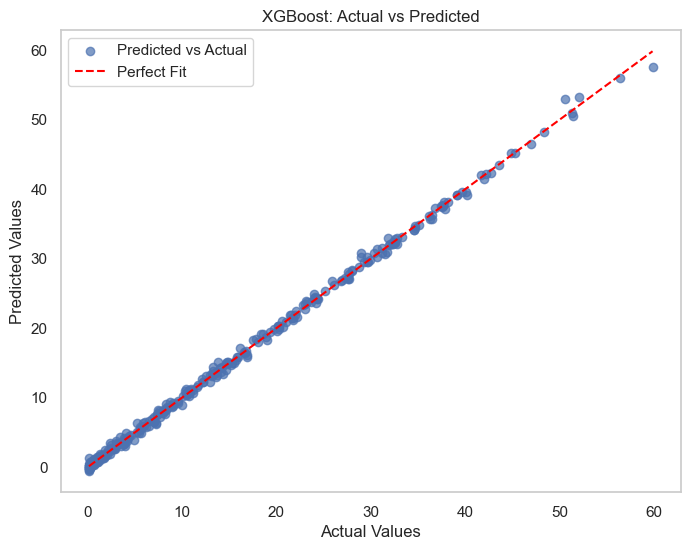

In [12]:
# plot y_true and y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_valid, y_reg_pred_xgb, alpha=0.7, label="Predicted vs Actual")
plt.plot([y_reg_valid.min(), y_reg_valid.max()], [y_reg_valid.min(), y_reg_valid.max()], color='red', linestyle='--', label="Perfect Fit")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("XGBoost: Actual vs Predicted")
plt.legend()
plt.grid()
plt.show()


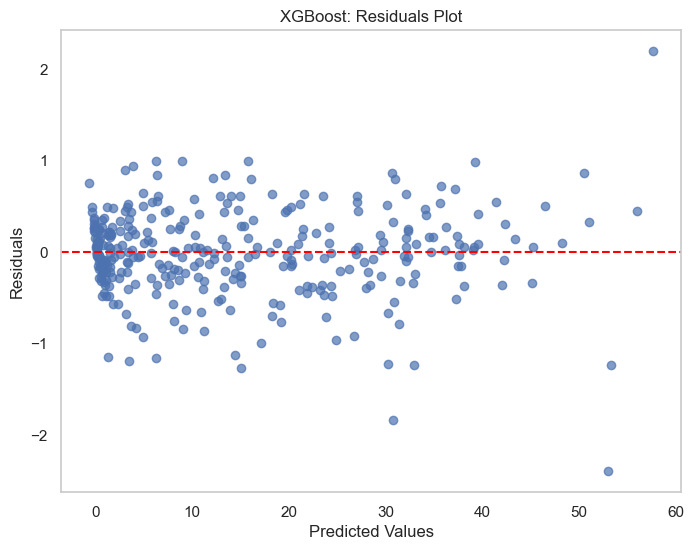

In [13]:
# compute residuals
residuals = y_reg_valid - y_reg_pred_xgb

# plot residuals
plt.figure(figsize=(8, 6))
plt.scatter(y_reg_pred_xgb, residuals, alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("XGBoost: Residuals Plot")
plt.grid()
plt.show()


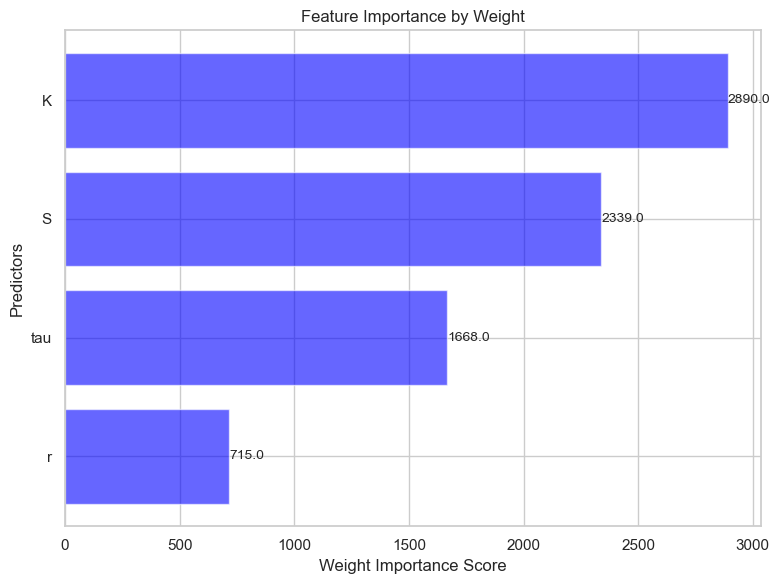

In [14]:
# get the importance of the predictors
importance = best_xgb_reg.get_booster().get_score(importance_type='weight')

importance_df = pd.DataFrame({
    'Feature': [f"f{i}" for i in range(len(regression_features))],  # 默认特征名
    'Original Name': regression_features,
    'Importance': [importance.get(f"f{i}", 0) for i in range(len(regression_features))]
})

# sort by importance 
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plot importance of predictors
plt.figure(figsize=(8, 6))  
plt.barh(importance_df['Original Name'], importance_df['Importance'], color='blue', alpha=0.6)

# show the value of importance
for index, value in enumerate(importance_df['Importance']):
    plt.text(value + 1, index, str(value), va='center', fontsize=10)  

plt.xlabel('Weight Importance Score')
plt.ylabel('Predictors')
plt.title('Feature Importance by Weight')
plt.gca().invert_yaxis()  
plt.tight_layout()  
# save the figure
plt.savefig('feature_importance_by_weight.png', dpi=300, bbox_inches='tight')  

plt.show()


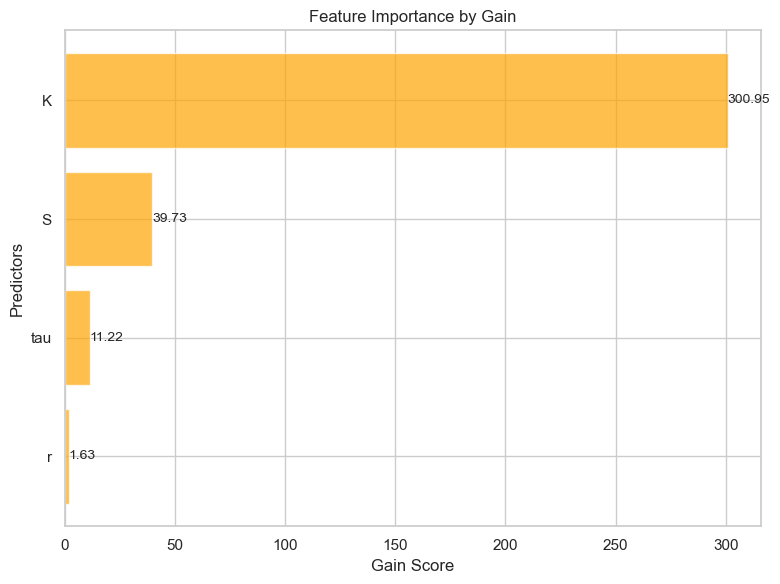

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# name of predictors
regression_features = ['S', 'K', 'tau', 'r'] 

# get the importance of predictors(by gain)
importance = best_xgb_reg.get_booster().get_score(importance_type='gain')

importance_df = pd.DataFrame({
    'Feature': [f"f{i}" for i in range(len(regression_features))],  
    'Original Name': regression_features,
    'Importance': [importance.get(f"f{i}", 0) for i in range(len(regression_features))]
})

# sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# plot importance of predictors
plt.figure(figsize=(8, 6))  
plt.barh(importance_df['Original Name'], importance_df['Importance'], color='orange', alpha=0.7)

for index, value in enumerate(importance_df['Importance']):
    plt.text(value, index, f'{value:.2f}', va='center', fontsize=10)

plt.xlabel('Gain Score')
plt.ylabel('Predictors')
plt.title('Feature Importance by Gain')
plt.gca().invert_yaxis()  # 翻转 y 轴
plt.tight_layout()

# save the figure
plt.savefig('feature_importance_gain.png', dpi=300, bbox_inches='tight') 
plt.show()


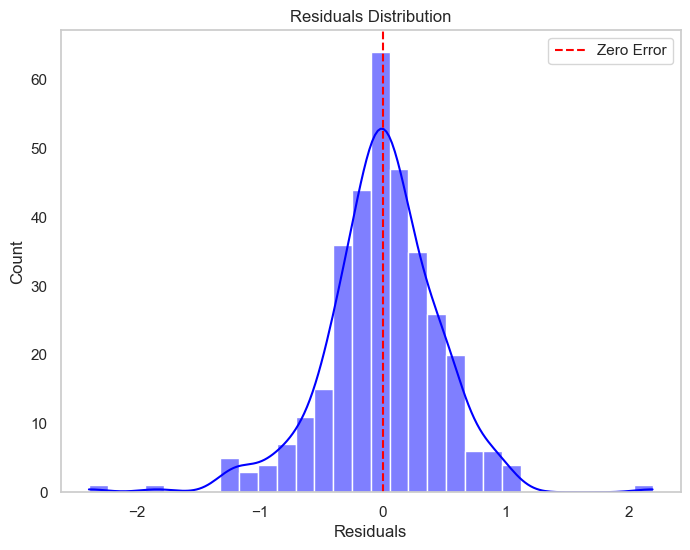

In [16]:
# plot distribution of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='blue')
plt.axvline(0, color='red', linestyle='--', label="Zero Error")
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.legend()
plt.grid()
plt.show()

pip install ace_tools

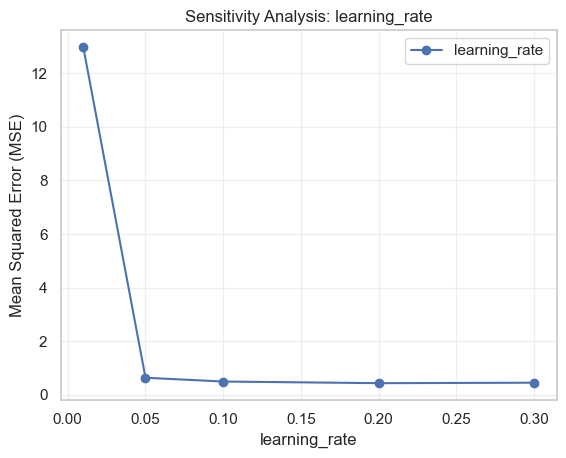

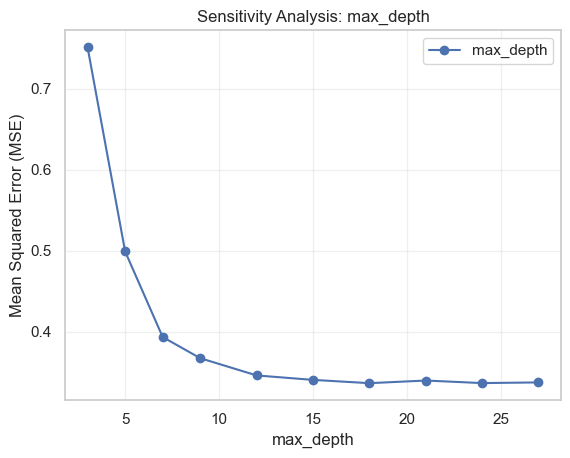

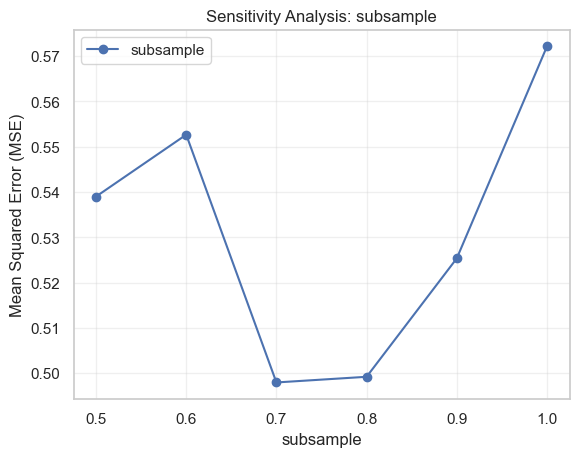

In [17]:
# parameter sensitive analysis
def sensitivity_analysis(param_name, param_values, fixed_params, X_train, y_train, X_valid, y_valid):
    results = []
    for value in param_values:
        params = fixed_params.copy()
        params[param_name] = value
        model = XGBRegressor(**params, random_state=42, objective='reg:squarederror')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        mse = mean_squared_error(y_valid, y_pred)
        results.append((value, mse))
    
    # plot the curve of sensitive analysis
    values, errors = zip(*results)
    plt.plot(values, errors, marker='o', label=param_name)
    plt.xlabel(param_name)
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'Sensitivity Analysis: {param_name}')
    plt.grid(alpha=0.3)
    plt.legend()
    plt.show()

# control other parameters and analyze learning_rate, max_depth, subsample
fixed_params = {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 10, 'min_child_weight': 5}
sensitivity_analysis('learning_rate', [0.01, 0.05, 0.1, 0.2, 0.3], fixed_params, X_reg_train_scaled, y_reg_train, X_reg_valid_scaled, y_reg_valid)
sensitivity_analysis('max_depth', [3, 5, 7, 9, 12,15,18,21,24,27], fixed_params, X_reg_train_scaled, y_reg_train, X_reg_valid_scaled, y_reg_valid)
sensitivity_analysis('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1], fixed_params, X_reg_train_scaled, y_reg_train, X_reg_valid_scaled, y_reg_valid)


In [18]:
# sensitive analysis function
def sensitivity_analysis_table(param_name, param_values, fixed_params, X_train, y_train, X_valid, y_valid):
    results = []
    for value in param_values:
        params = fixed_params.copy()
        params[param_name] = value
        model = XGBRegressor(**params, random_state=42, objective='reg:squarederror')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        mse = mean_squared_error(y_valid, y_pred)
        results.append({'Parameter': param_name, 'Value': value, 'MSE': mse})
    return results

# analyze learning_rate, max_depth, subsample
learning_rate_results = sensitivity_analysis_table('learning_rate', [0.01, 0.05, 0.1, 0.2, 0.3, 0.4], fixed_params, X_reg_train_scaled, y_reg_train, X_reg_valid_scaled, y_reg_valid)
max_depth_results = sensitivity_analysis_table('max_depth', [3, 4, 5, 6, 7, 8], fixed_params, X_reg_train_scaled, y_reg_train, X_reg_valid_scaled, y_reg_valid)
subsample_results = sensitivity_analysis_table('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1], fixed_params, X_reg_train_scaled, y_reg_train, X_reg_valid_scaled, y_reg_valid)

# save in a dataframe
results_df = pd.DataFrame({
    'learning_rate': [res['Value'] for res in learning_rate_results] + [None] * (6 - len(learning_rate_results)),
    'learning_rate_mse': [res['MSE'] for res in learning_rate_results] + [None] * (6 - len(learning_rate_results)),
    'max_depth': [res['Value'] for res in max_depth_results] + [None] * (6 - len(max_depth_results)),
    'max_depth_mse': [res['MSE'] for res in max_depth_results] + [None] * (6 - len(max_depth_results)),
    'subsample': [res['Value'] for res in subsample_results] + [None] * (6 - len(subsample_results)),
    'subsample_mse': [res['MSE'] for res in subsample_results] + [None] * (6 - len(subsample_results))
})

# print the table
results_df

,learning_rate,learning_rate_mse,max_depth,max_depth_mse,subsample,subsample_mse
0,0.01,12.963668,3,0.751383,0.5,0.538993
1,0.05,0.640425,4,0.498076,0.6,0.552652
2,0.10,0.499203,5,0.499203,0.7,0.497953
3,0.20,0.438239,6,0.413839,0.8,0.499203
4,0.30,0.455542,7,0.393500,0.9,0.525343
5,0.40,0.478052,8,0.378117,1.0,0.572131


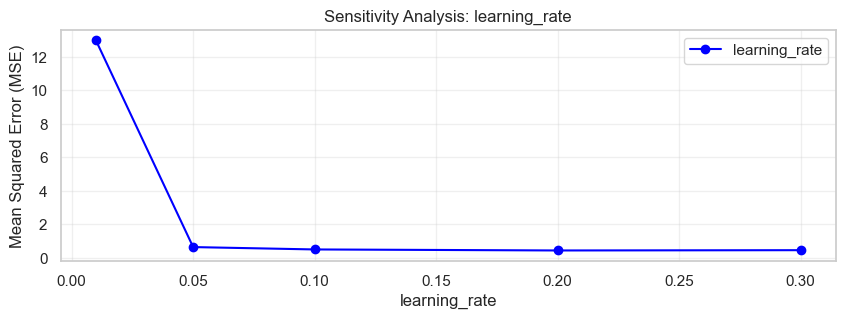

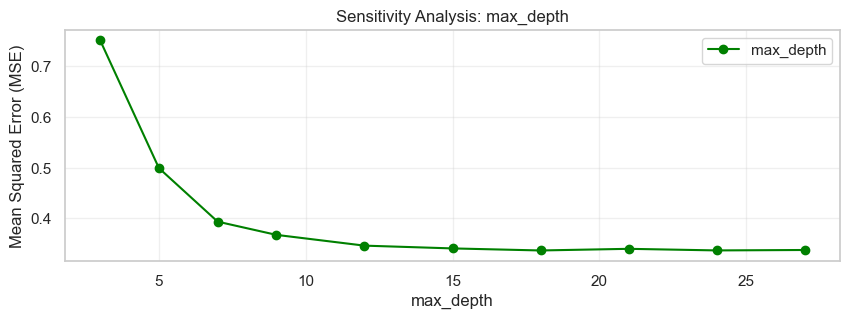

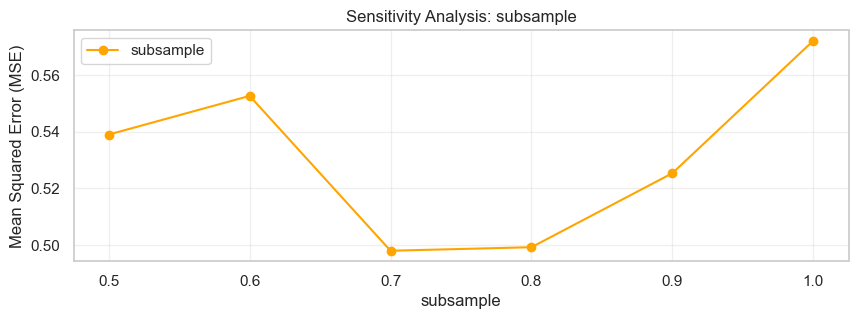

In [19]:
# define sensitive analysis function
def sensitivity_analysis(param_name, param_values, fixed_params, X_train, y_train, X_valid, y_valid, color, filename):
    results = []
    for value in param_values:
        params = fixed_params.copy()
        params[param_name] = value
        model = XGBRegressor(**params, random_state=42, objective='reg:squarederror')
        model.fit(X_train, y_train)
        y_pred = model.predict(X_valid)
        mse = mean_squared_error(y_valid, y_pred)
        results.append((value, mse))
    
    # plot sensitive analysis curve
    values, errors = zip(*results)
    plt.figure(figsize=(10, 3))  
    plt.plot(values, errors, marker='o', color=color, label=param_name)
    plt.xlabel(param_name)
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title(f'Sensitivity Analysis: {param_name}')
    plt.grid(alpha=0.3)
    plt.legend()
    
    # save the figure
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()

# fix other parameters and analyze learning_rate, max_depth, subsample
fixed_params = {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.8, 'reg_alpha': 0.1, 'reg_lambda': 10, 'min_child_weight': 5}

# define color
colors = ['blue', 'green', 'orange']

# plot three sensitive analysis curves
sensitivity_analysis('learning_rate', [0.01, 0.05, 0.1, 0.2, 0.3], fixed_params, X_reg_train_scaled, y_reg_train, X_reg_valid_scaled, y_reg_valid, colors[0], "learning_rate_sensitivity.png")
sensitivity_analysis('max_depth', [3, 5, 7, 9, 12, 15, 18, 21, 24, 27], fixed_params, X_reg_train_scaled, y_reg_train, X_reg_valid_scaled, y_reg_valid, colors[1], "max_depth_sensitivity.png")
sensitivity_analysis('subsample', [0.5, 0.6, 0.7, 0.8, 0.9, 1], fixed_params, X_reg_train_scaled, y_reg_train, X_reg_valid_scaled, y_reg_valid, colors[2], "subsample_sensitivity.png")

## Support Vector Regression (SVR)

In [21]:
# create SVR model
svr_model = SVR()
# parameters grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 1],
    'kernel': ['linear','rbf']
}

# use GridSearchCV and CV to find best parameters
grid_search = GridSearchCV(svr_model, param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_search.fit(X_reg_train_scaled, y_reg_train)
best_svr_reg = grid_search.best_estimator_
print(f"\nBest SVR model parameters: {grid_search.best_params_}")

# calculate out-of-sample R2
y_reg_pred = best_svr_reg.predict(X_reg_valid_scaled)
out_of_sample_r2 = r2_score(y_reg_valid, y_reg_pred)

print(f"Out-of-Sample R^2: {out_of_sample_r2}")


Best SVR model parameters: {'C': 100, 'epsilon': 0.01, 'kernel': 'rbf'}
Out-of-Sample R^2: 0.999550488989827


## Linear Regression Model

In [22]:
# create a linear model
linear_model = LinearRegression()

# train on training set
linear_model.fit(X_reg_train_scaled, y_reg_train)

# predict on validation set
y_reg_pred = linear_model.predict(X_reg_valid_scaled)

# calculate Out-of-Sample R^2
out_of_sample_r2 = r2_score(y_reg_valid, y_reg_pred)
print(f"Out-of-Sample R^2: {out_of_sample_r2}")


Out-of-Sample R^2: 0.9114066695745033


## Polynomial Regression Model

In [23]:
# create a linear model
linear_model = LinearRegression()

# parameter grids
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4]  # degree
}

# create a pipeline for polynomial regression model
pipeline = Pipeline([
    ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
    ('linearregression', linear_model)
])

# use GridSearchCV and CV to find best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_search.fit(X_reg_train_scaled, y_reg_train)

# get the best model and parameters
best_linear_reg = grid_search.best_estimator_
print(f"\nBest Polynomial Regression Model parameters: {grid_search.best_params_}")

# predict on validation set
y_reg_pred = best_linear_reg.predict(X_reg_valid_scaled)

# calculate out-of-sample R^2
out_of_sample_r2 = r2_score(y_reg_valid, y_reg_pred)
print(f"Out-of-Sample R^2: {out_of_sample_r2}")


Best Polynomial Regression Model parameters: {'polynomialfeatures__degree': 4}
Out-of-Sample R^2: 0.9990928727446138


## Polynomial Ridge Model

In [24]:
# create a ridge model
ridge_model = Ridge()

# parameters grid
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4],  # degree
    'ridge__alpha': [0.1, 1, 10, 100] 
}

# create a pipeline
pipeline = Pipeline([
    ('polynomialfeatures', PolynomialFeatures(include_bias=False)),
    ('ridge', ridge_model)
])

# use GridSearchCV and CV to find best parameters
grid_search = GridSearchCV(pipeline, param_grid, cv=10, scoring='r2', n_jobs=-1)
grid_search.fit(X_reg_train_scaled, y_reg_train)

# get best parameters and model
best_ridge_reg = grid_search.best_estimator_
print(f"\nbest Polynomial Ridge Model parameters：{grid_search.best_params_}")

# predict on validation set
y_reg_pred = best_ridge_reg.predict(X_reg_valid_scaled)

# calculate out-of-sample R^2
out_of_sample_r2 = r2_score(y_reg_valid, y_reg_pred)
print(f"Out-of-Sample R^2: {out_of_sample_r2}")


best Polynomial Ridge Model parameters：{'polynomialfeatures__degree': 4, 'ridge__alpha': 0.1}
Out-of-Sample R^2: 0.999094769188358


# Classification Models

## RandomForestClassifier

In [25]:
# create a random forest classifier
rf_clf = RandomForestClassifier(random_state=42)

# parameters grid
param_grid_rf_clf = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'class_weight': ['balanced', None]
}

# grid search
grid_search_rf_clf = GridSearchCV(estimator=rf_clf, param_grid=param_grid_rf_clf,
                                  cv=5, n_jobs=-1, scoring='accuracy')
grid_search_rf_clf.fit(X_clf_train_scaled, y_clf_train)

# best model
best_rf_clf = grid_search_rf_clf.best_estimator_
print(f"\nBest Random Forest parameters：{grid_search_rf_clf.best_params_}")

# predict on validation set
y_clf_pred_rf = best_rf_clf.predict(X_clf_valid_scaled)
accuracy_rf = accuracy_score(y_clf_valid, y_clf_pred_rf)
print(f"Accuract of the RandomForestClassifier: {accuracy_rf:.4f}")

# print the report
print("\report of RandomForestClassifier：")
print(classification_report(y_clf_valid, y_clf_pred_rf))


Best Random Forest parameters：{'class_weight': None, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
Accuract of the RandomForestClassifier: 0.9375
eport of RandomForestClassifier：
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       178
           1       0.94      0.93      0.93       158

    accuracy                           0.94       336
   macro avg       0.94      0.94      0.94       336
weighted avg       0.94      0.94      0.94       336



## Support Vector Classifier

In [26]:
# create a svc model
svc_clf = SVC(random_state=42)

# set parameters grid
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# grid search and cross validate
grid_search_svc = GridSearchCV(estimator=svc_clf, param_grid=param_grid_svc,
                               cv=5, n_jobs=-1, scoring='accuracy')
grid_search_svc.fit(X_clf_train_scaled, y_clf_train)

# best model
best_svc_clf = grid_search_svc.best_estimator_
print(f"\nBest SVC parameters: {grid_search_svc.best_params_}")

# predict on validation set
y_clf_pred_svc = best_svc_clf.predict(X_clf_valid_scaled)
accuracy_svc = accuracy_score(y_clf_valid, y_clf_pred_svc)
print(f"SVC accuracy：{accuracy_svc:.4f}")

# print the classification report
print("\nreport of SVC：")
print(classification_report(y_clf_valid, y_clf_pred_svc))


Best SVC parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
SVC accuracy：0.9375

report of SVC：
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       178
           1       0.93      0.94      0.93       158

    accuracy                           0.94       336
   macro avg       0.94      0.94      0.94       336
weighted avg       0.94      0.94      0.94       336



## XGBClassifier

In [27]:
# create a XGBClassifier
#xgb_clf = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_clf = XGBClassifier(random_state=42, eval_metric='logloss')

# parameters grid
param_grid_xgb_clf = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.7, 1]
}

# grid search and cross validation
grid_search_xgb_clf = GridSearchCV(estimator=xgb_clf, param_grid=param_grid_xgb_clf,
                                   cv=5, n_jobs=-1, scoring='accuracy')
grid_search_xgb_clf.fit(X_clf_train_scaled, y_clf_train)

# best model
best_xgb_clf = grid_search_xgb_clf.best_estimator_
print(f"\nBest XGBoost classifier parameters：{grid_search_xgb_clf.best_params_}")

# predict on validation set
y_clf_pred_xgb = best_xgb_clf.predict(X_clf_valid_scaled)
accuracy_xgb = accuracy_score(y_clf_valid, y_clf_pred_xgb)
print(f"XGBoost classifier accuracy：{accuracy_xgb:.4f}")

# print the classification report
print("\nXGBoost classifier report")
print(classification_report(y_clf_valid, y_clf_pred_xgb))


Best XGBoost classifier parameters：{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.7}
XGBoost classifier accuracy：0.9375

XGBoost classifier report
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       178
           1       0.93      0.94      0.93       158

    accuracy                           0.94       336
   macro avg       0.94      0.94      0.94       336
weighted avg       0.94      0.94      0.94       336



## Logistic Regression

In [28]:
# create a logistic regression model
logreg_model = LogisticRegression(max_iter=1000)

# parameters grid
param_grid = {
    'C': [0.1, 1, 10, 100],  
    'penalty': ['l2', 'none'],  
    'solver': ['lbfgs', 'saga']  
}

# use GridSearchCV and cross validation to find best parameters
grid_search1 = GridSearchCV(logreg_model, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search1.fit(X_clf_train_scaled, y_clf_train)

# print best parameters
print(f"Best Parameters: {grid_search1.best_params_}")

# use the model with best parameters
best_logreg = grid_search1.best_estimator_

# calculate Out-of-Sample Accuracy
y_pred = best_logreg.predict(X_clf_valid_scaled)
out_of_sample_accuracy = accuracy_score(y_clf_valid, y_pred)
print(f"Out-of-Sample Accuracy: {out_of_sample_accuracy}")

# print classification report
print("Classification Report:\n", classification_report(y_clf_valid, y_pred))

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Out-of-Sample Accuracy: 0.9136904761904762
Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       178
           1       0.92      0.89      0.91       158

    accuracy                           0.91       336
   macro avg       0.91      0.91      0.91       336
weighted avg       0.91      0.91      0.91       336



## KNN

In [29]:
# create a KNN classifier
knn_model = KNeighborsClassifier()

# parameters grid
param_grid = {
    'n_neighbors': list(range(1, 51)),  
    'weights': ['uniform', 'distance'],  
    'metric': ['euclidean', 'manhattan', 'minkowski'] 
}

# use GridSearchCV and cross validation to find best parameters
grid_search1 = GridSearchCV(knn_model, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search1.fit(X_clf_train_scaled, y_clf_train)

# print the best parameters
print(f"Best Parameters: {grid_search1.best_params_}")

# use the model with best parameters
best_knn = grid_search1.best_estimator_

# calculate Out-of-Sample Accuracy
y_pred = best_knn.predict(X_clf_valid_scaled)
out_of_sample_accuracy = accuracy_score(y_clf_valid, y_pred)
print(f"Out-of-Sample Accuracy: {out_of_sample_accuracy}")

# print the classification report
print("Classification Report:\n", classification_report(y_clf_valid, y_pred))

Best Parameters: {'metric': 'manhattan', 'n_neighbors': 35, 'weights': 'distance'}
Out-of-Sample Accuracy: 0.9464285714285714
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       178
           1       0.94      0.94      0.94       158

    accuracy                           0.95       336
   macro avg       0.95      0.95      0.95       336
weighted avg       0.95      0.95      0.95       336



## Naive Bayes

In [30]:
# create a Naive Bayes classifier
nb_model = GaussianNB()

nb_model.fit(X_clf_train_scaled, y_clf_train)

# calculate Out-of-Sample Accuracy
y_pred = nb_model.predict(X_clf_valid_scaled)
out_of_sample_accuracy = accuracy_score(y_clf_valid, y_pred)
print(f"Out-of-Sample Accuracy: {out_of_sample_accuracy}")

Out-of-Sample Accuracy: 0.8809523809523809


## Decision Tree

In [31]:
# create a decision tree
dt_model = DecisionTreeClassifier()

# parameters grid
param_grid = {
    'criterion': ['gini', 'entropy'],  
    'max_depth': [None, 5, 10, 20],  
    'min_samples_split': [2, 5, 10], 
    'min_samples_leaf': [1, 2, 4]  
}

# use GridSearchCV and cross validation
grid_search = GridSearchCV(dt_model, param_grid, cv=10, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_clf_train_scaled, y_clf_train)

# best parameters
print(f"Best Parameters: {grid_search.best_params_}")

# best model
best_dt_model = grid_search.best_estimator_

# predict on validation set
y_pred = best_dt_model.predict(X_clf_valid_scaled)

# calculate Out-of-Sample Accuracy
out_of_sample_accuracy = accuracy_score(y_clf_valid, y_pred)
print(f"Out-of-Sample Accuracy: {out_of_sample_accuracy}")

# print classification report
print("Classification Report:\n", classification_report(y_clf_valid, y_pred))

Best Parameters: {'criterion': 'gini', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Out-of-Sample Accuracy: 0.9166666666666666
Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.92      0.92       178
           1       0.91      0.92      0.91       158

    accuracy                           0.92       336
   macro avg       0.92      0.92      0.92       336
weighted avg       0.92      0.92      0.92       336



## LDA

In [32]:
# create a LDA model
lda_model = LinearDiscriminantAnalysis()

# fit on training set
lda_model.fit(X_clf_train_scaled, y_clf_train)

# calculate Out-of-Sample Accuracy
y_pred = lda_model.predict(X_clf_valid_scaled)
out_of_sample_accuracy = accuracy_score(y_clf_valid, y_pred)
print(f"Out-of-Sample Accuracy: {out_of_sample_accuracy}")

Out-of-Sample Accuracy: 0.9196428571428571


## QDA

In [33]:
# create a QDA model
qda_model = QuadraticDiscriminantAnalysis()

# fit on training set
qda_model.fit(X_clf_train_scaled, y_clf_train)

# calculate Out-of-Sample Accuracy
y_pred = qda_model.predict(X_clf_valid_scaled)
out_of_sample_accuracy = accuracy_score(y_clf_valid, y_pred)
print(f"Out-of-Sample Accuracy: {out_of_sample_accuracy}")

Out-of-Sample Accuracy: 0.9285714285714286


## ROC Curve

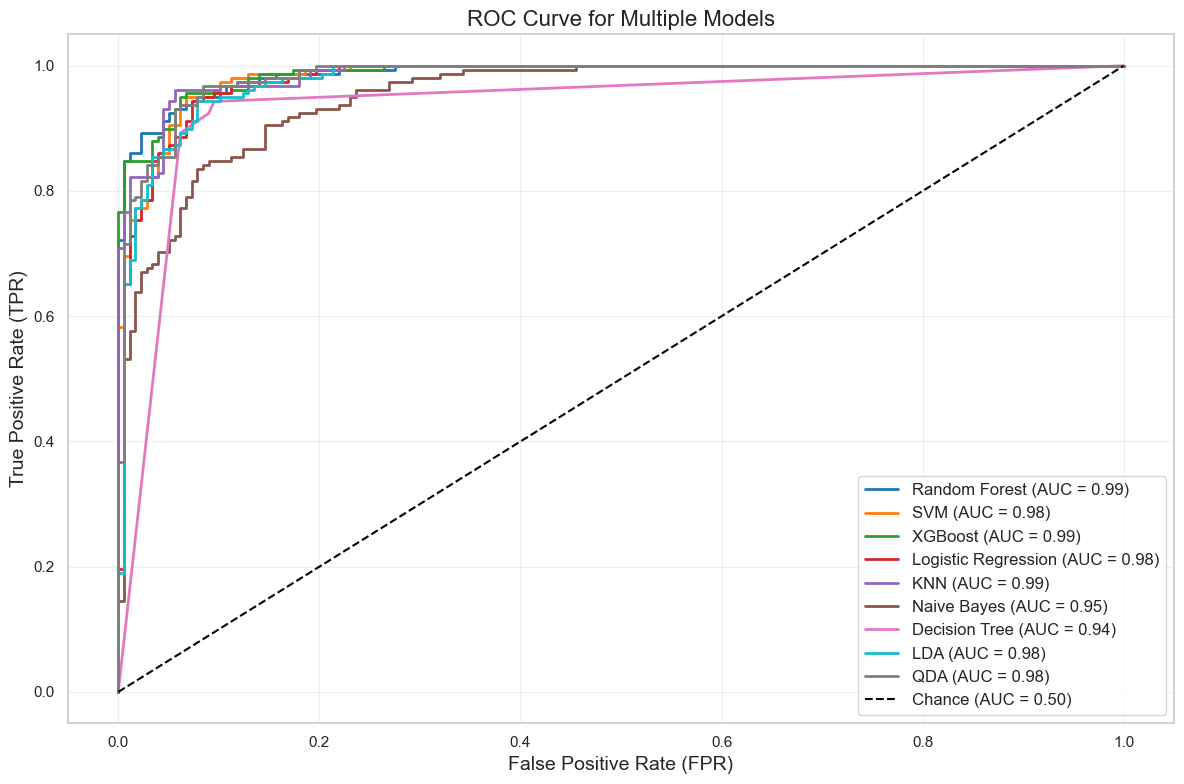

In [34]:
# roc curve
# color map
color_map = {
    "Random Forest": "#1f77b4",   # blue
    "SVM": "#ff7f0e",            # orange
    "XGBoost": "#2ca02c",        # green
    "Logistic Regression": "#d62728",  # red
    "KNN": "#9467bd",            # purple
    "Naive Bayes": "#8c564b",    # brown
    "Decision Tree": "#e377c2",  # pink
    "QDA": "#7f7f7f",            # gray
    "LDA": "#17becf",            # cyan
}

def compute_roc_auc(model, X_valid_scaled, y_valid, model_name):
    """
    compute ROC curve AUC value
    """
    # check if the model support predict_proba or decision_function
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_valid_scaled)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_valid_scaled)
    else:
        raise ValueError(f"Model {model_name} does not support probability or decision output.")

    # calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_valid, y_proba)
    roc_auc = auc(fpr, tpr)

    # return results
    return fpr, tpr, roc_auc

# plot ROC curves
plt.figure(figsize=(12, 8))

# model list
models = [
    (best_rf_clf, "Random Forest"),
    (best_svc_clf, "SVM"),
    (best_xgb_clf, "XGBoost"),
    (best_logreg, "Logistic Regression"),
    (best_knn, "KNN"),
    (nb_model, "Naive Bayes"),
    (best_dt_model, "Decision Tree"),
    (lda_model, "LDA"),
    (qda_model, "QDA"),
]

for model, model_name in models:
    fpr, tpr, roc_auc = compute_roc_auc(model, X_clf_valid_scaled, y_clf_valid, model_name)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})', color=color_map[model_name])

# plot a baseline
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1.5, label='Chance (AUC = 0.50)')

# add title and labels
plt.title('ROC Curve for Multiple Models', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)

# save the figure
plt.tight_layout()  
plt.savefig("roc_curve_comparison.png", dpi=300, bbox_inches='tight')  
plt.show()


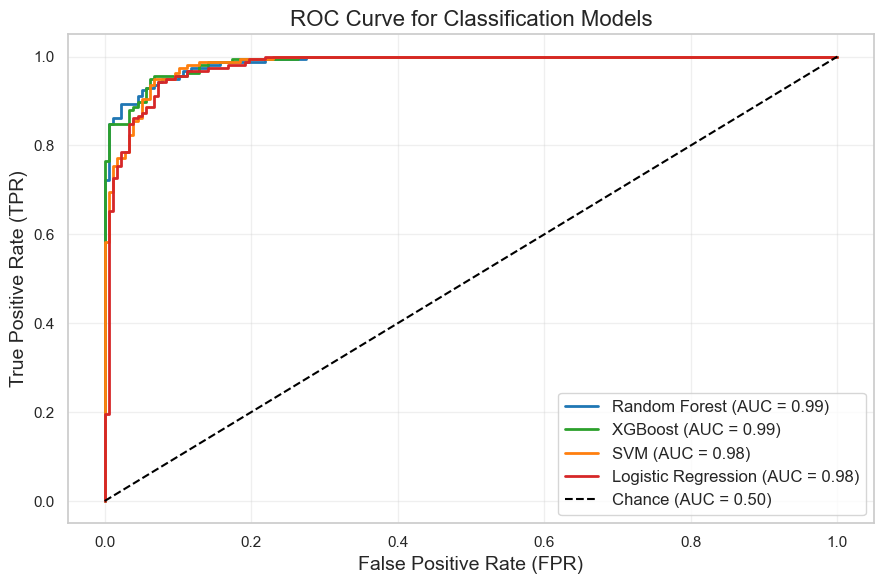

In [35]:
# choose four models with highest auc
selected_models = [
    (best_rf_clf, "Random Forest"),
    (best_xgb_clf, "XGBoost"),
    (best_svc_clf, "SVM"),
    (best_logreg, "Logistic Regression")
]

# color map
optimized_color_map = {
    "Random Forest": "#1f77b4",  # blue
    "XGBoost": "#2ca02c",       # green
    "SVM": "#ff7f0e",           # orange
    "Logistic Regression": "#d62728"  # red
}

# plot ROC curve
plt.figure(figsize=(9, 6))

for model, model_name in selected_models:
    fpr, tpr, roc_auc = compute_roc_auc(model, X_clf_valid_scaled, y_clf_valid, model_name)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})', color=optimized_color_map[model_name])

# plot baseline
plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1.5, label='Chance (AUC = 0.50)')

# add title and labels
plt.title('ROC Curve for Classification Models', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)

# save figure
plt.tight_layout()
plt.savefig("optimized_roc_curve.png", dpi=300, bbox_inches='tight')
plt.show()


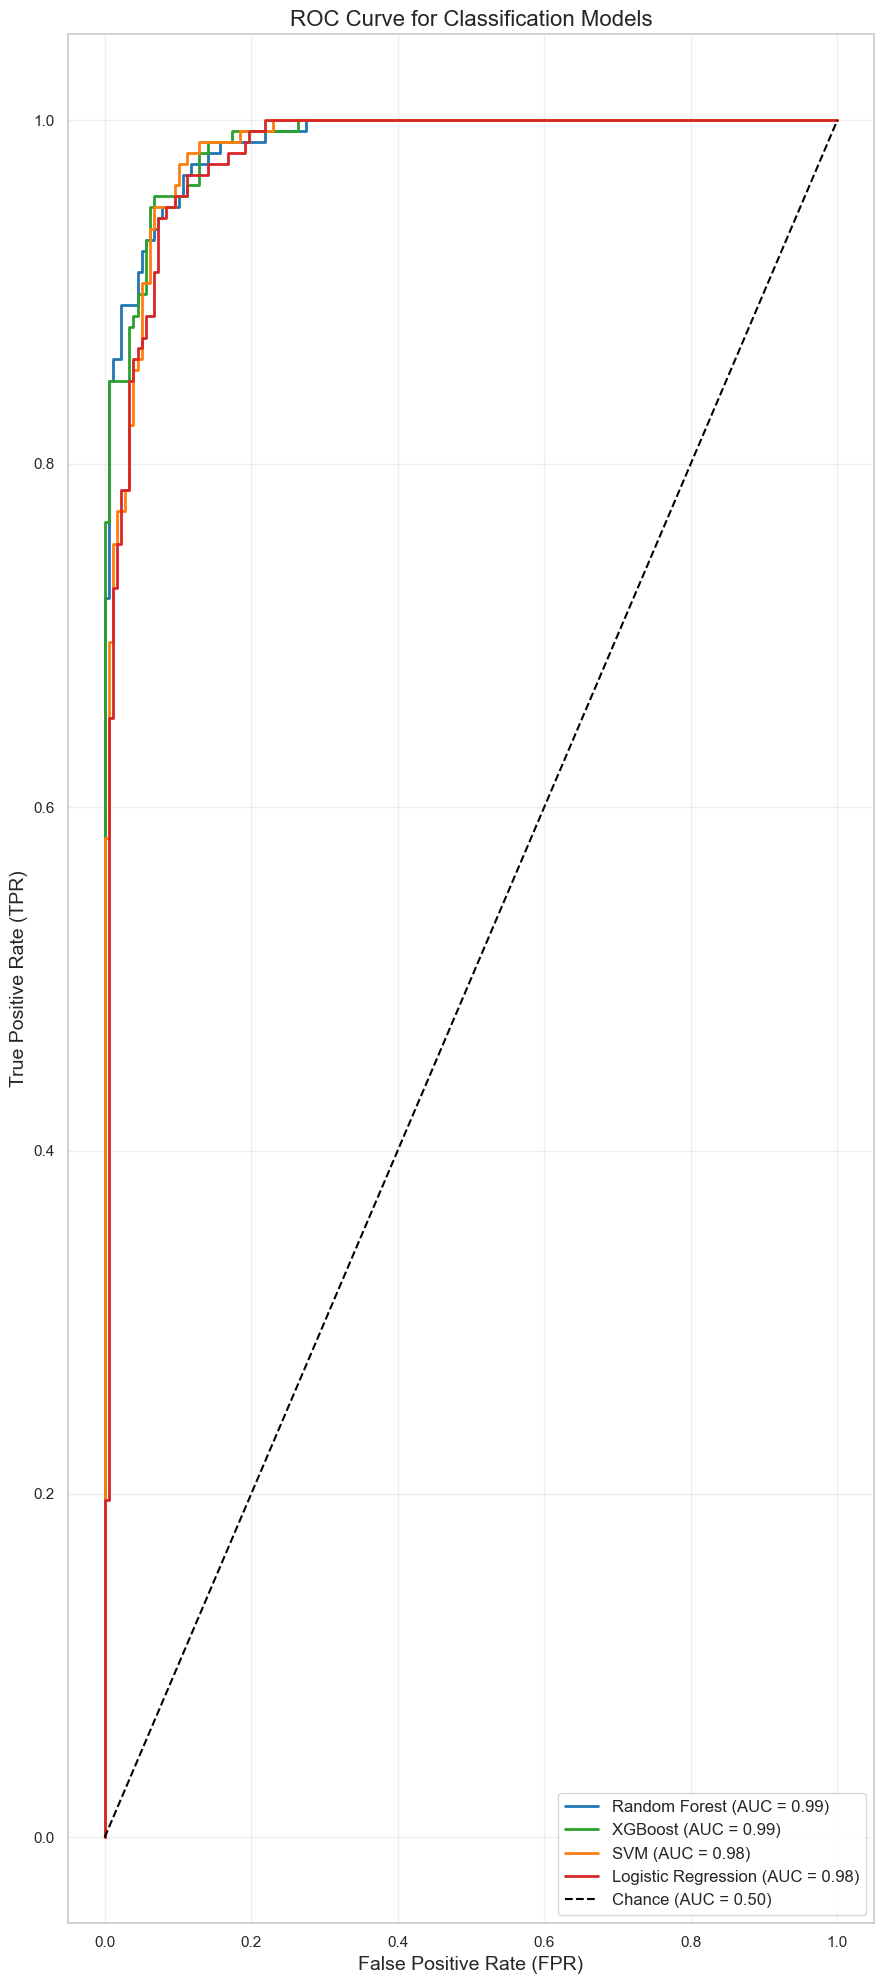

In [36]:
selected_models = [
    (best_rf_clf, "Random Forest"),
    (best_xgb_clf, "XGBoost"),
    (best_svc_clf, "SVM"),
    (best_logreg, "Logistic Regression")
]

optimized_color_map = {
    "Random Forest": "#1f77b4",  
    "XGBoost": "#2ca02c",      
    "SVM": "#ff7f0e",           
    "Logistic Regression": "#d62728"  
}


plt.figure(figsize=(9, 20))

for model, model_name in selected_models:
    fpr, tpr, roc_auc = compute_roc_auc(model, X_clf_valid_scaled, y_clf_valid, model_name)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})', color=optimized_color_map[model_name])


plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1.5, label='Chance (AUC = 0.50)')


plt.title('ROC Curve for Classification Models', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)


plt.tight_layout()
plt.savefig("optimized_roc_curve1.png", dpi=300, bbox_inches='tight')
plt.show()


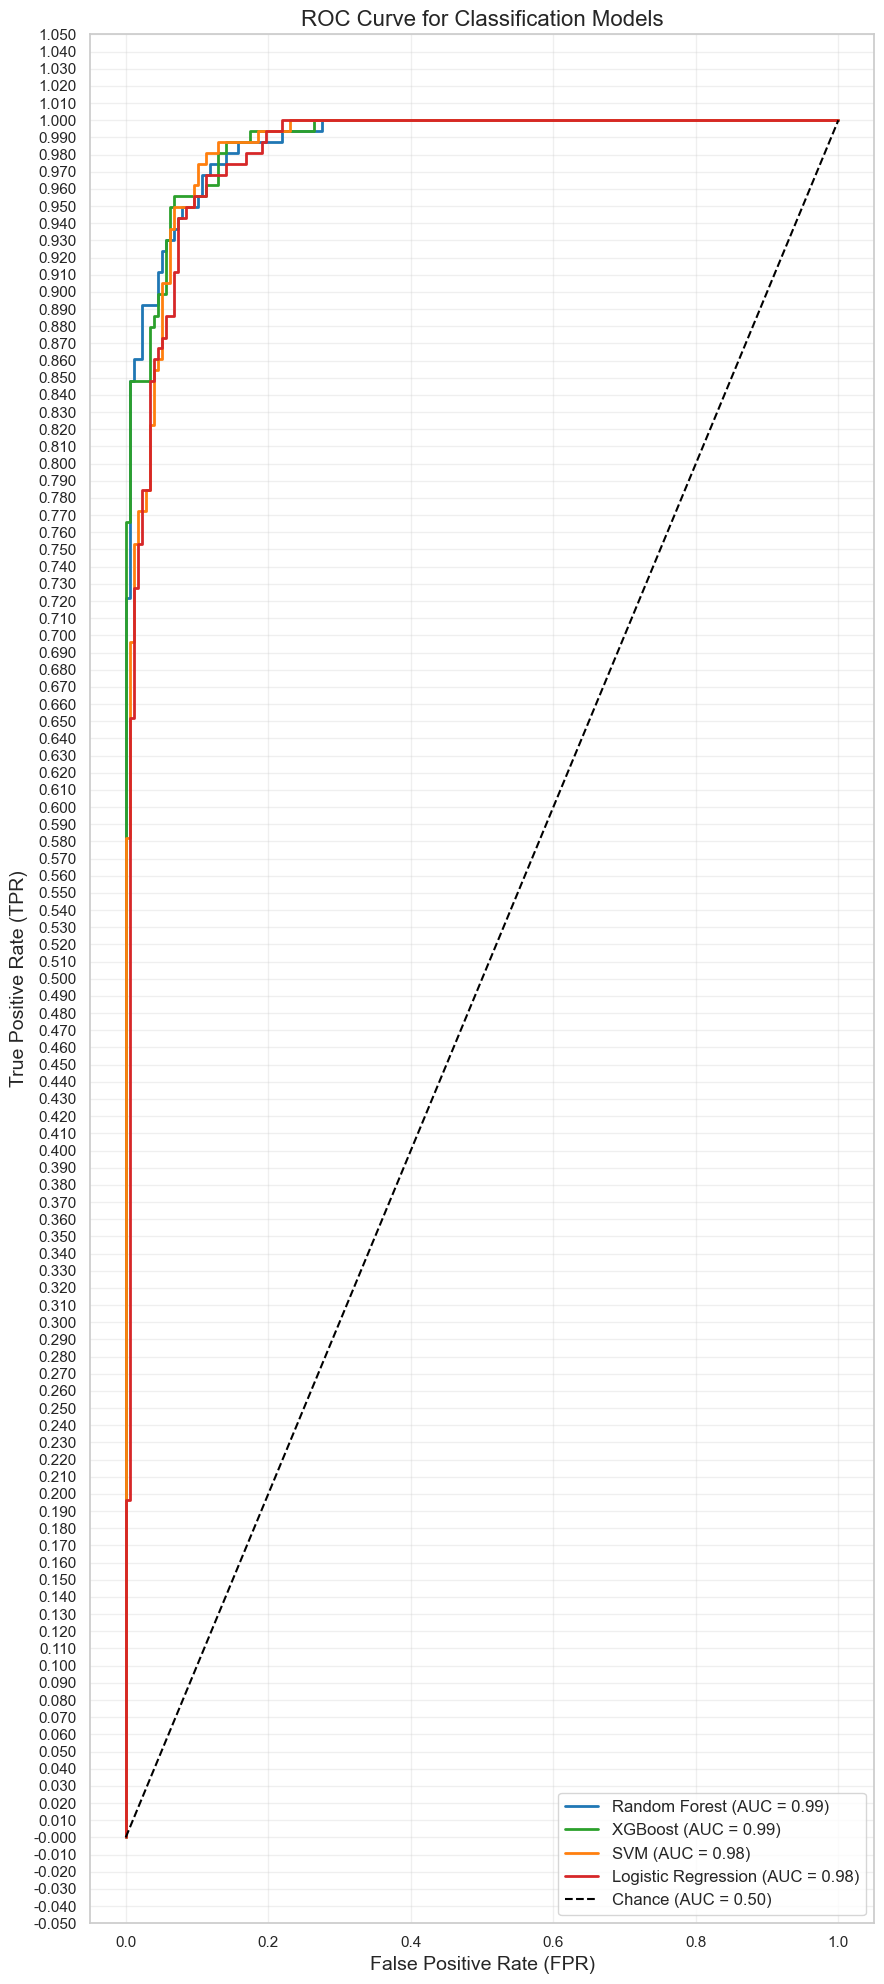

In [37]:
plt.figure(figsize=(9, 20))

for model, model_name in selected_models:
    fpr, tpr, roc_auc = compute_roc_auc(model, X_clf_valid_scaled, y_clf_valid, model_name)
    plt.plot(fpr, tpr, lw=2, label=f'{model_name} (AUC = {roc_auc:.2f})', color=optimized_color_map[model_name])

plt.plot([0, 1], [0, 1], color='black', linestyle='--', lw=1.5, label='Chance (AUC = 0.50)')

plt.title('ROC Curve for Classification Models', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)

plt.gca().yaxis.set_major_locator(MultipleLocator(0.01))  
#plt.gca().yaxis.set_minor_locator(MultipleLocator(0.01))
plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f')) 

plt.legend(loc='lower right', fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("optimized_roc_curve_finer_y_axis.png", dpi=300, bbox_inches='tight')
plt.show()


# Predict on test set

In [45]:
# predict on test set（SVR+KNN）
# regression
test_reg_pred = best_svr_reg.predict(X_test_reg_scaled)
test_reg_pred = test_reg_pred.astype(float)

# classification
test_clf_pred = best_knn.predict(X_test_clf_scaled)
test_clf_pred = test_clf_pred.astype(int)

In [46]:
# submission
submission = pd.DataFrame({
    'Value': test_reg_pred,
    'BS': test_clf_pred
})

# save the file
submission.to_csv('group_2_prediction.csv', index=False)
print("\nResults are saved as 'group_2_prediction.csv'")


Results are saved as 'group_2_prediction.csv'
